In [1]:
import os
import yaml
import shutil
from pathlib import Path
from tqdm import tqdm
from PIL import Image

# Giả định bạn đã cài đặt mlstruct-fp
from MLStructFP.db import DbLoader
from MLStructFP.utils import GeomPoint2D  # Import GeomPoint2D để biến đổi điểm

In [2]:
# =================================================================================
# --- 1. PHẦN CẤU HÌNH (VUI LÒNG CHỈNH SỬA) ---
# =================================================================================

# Đường dẫn tới file json của database
DB_JSON_PATH = 'dataset/fp.json'

# Thư mục gốc để tạo dataset YOLO mới
# Script sẽ tự tạo cấu trúc: ./damage_dataset/images/ và ./damage_dataset/labels/
OUTPUT_DATASET_DIR = 'mlstruct_dataset'

# Ánh xạ tên lớp sang chỉ số (integer).
# TODO: Bạn cần có logic để gán lớp cho mỗi `rect`. 
# Ví dụ này tạm gán tất cả là lớp 'damage'.
CLASS_MAP = {
    'wall': 0,
}

In [3]:
"""
Chuyển đổi dữ liệu từ DbLoader sang định dạng YOLO Segmentation,
đồng thời sao chép file ảnh để tạo một bộ dataset hoàn chỉnh.
"""
print("🚀 Bắt đầu tạo bộ dataset YOLO hoàn chỉnh...")

# --- Thiết lập cấu trúc thư mục ---
dataset_root = Path(OUTPUT_DATASET_DIR)
images_dir = dataset_root / 'images/train'
labels_dir = dataset_root / 'labels/train'
images_dir.mkdir(parents=True, exist_ok=True)
labels_dir.mkdir(parents=True, exist_ok=True)
print(f"📁 Đã tạo cấu trúc thư mục tại: {dataset_root.resolve()}")

# --- Khởi tạo DbLoader ---
db = DbLoader(DB_JSON_PATH)
db_base_path = Path(db.path)  # Đường dẫn gốc của file db.json
floors = db.floors
print(f"🔎 Tìm thấy {len(floors)} bản vẽ (Floors) để xử lý.")

🚀 Bắt đầu tạo bộ dataset YOLO hoàn chỉnh...
📁 Đã tạo cấu trúc thư mục tại: /mnt/c/Users/admin/source/repos/agent-proj/MLSTRUCT/MLSTRUCT-FP/mlstruct_dataset
🔎 Tìm thấy 954 bản vẽ (Floors) để xử lý.


In [4]:
def normalized_points_to_bbox(normalized_points: list[float]) -> tuple[float, float, float, float]:
    """
    Chuyển đổi một danh sách các điểm polygon đã chuẩn hóa thành bounding box YOLO.

    Args:
        normalized_points: Danh sách các tọa độ đã chuẩn hóa [x1, y1, x2, y2, ...].

    Returns:
        Một tuple chứa (x_center, y_center, width, height).
    """
    if not normalized_points or len(normalized_points) % 2 != 0:
        return 0, 0, 0, 0

    x_coords = normalized_points[0::2]
    y_coords = normalized_points[1::2]

    x_min = min(x_coords)
    x_max = max(x_coords)
    y_min = min(y_coords)
    y_max = max(y_coords)

    width = x_max - x_min
    height = y_max - y_min
    x_center = x_min + (width / 2)
    y_center = y_min + (height / 2)

    return x_center, y_center, width, height

In [5]:
# --- Bắt đầu xử lý ---
for floor in floors:
    
    # 1. Xử lý đường dẫn ảnh
    image_relative_path = floor.image_path
    if not image_relative_path:
        continue
    source_image_path = db_base_path / image_relative_path
    dest_image_path = images_dir / source_image_path.name
    
    # 2. Sao chép file ảnh vào thư mục dataset
    if source_image_path.is_file():
        shutil.copy(source_image_path, dest_image_path)
    else:
        print(f"\n⚠️ Cảnh báo: Bỏ qua vì không tìm thấy file ảnh nguồn: {source_image_path}")
        continue
        
    # Lấy kích thước ảnh pixel thực tế
    try:
        with Image.open(source_image_path) as img:
            img_width, img_height = img.size
    except Exception as e:
        print(f"\n⚠️ Lỗi khi đọc ảnh {source_image_path}: {e}. Bỏ qua...")
        continue

    # 3. Chuẩn bị cho việc chuyển đổi tọa độ
    label_filename = source_image_path.stem + '.txt'
    label_filepath = labels_dir / label_filename
    
    bbox = floor.bounding_box
    geom_width = bbox.xmax - bbox.xmin
    geom_height = bbox.ymax - bbox.ymin

    angle = floor.mutator_angle
    scale = floor.image_scale
    scale_x = floor.mutator_scale_x
    scale_y = floor.mutator_scale_y

    # Tâm hình học của ảnh
    center_geom_x = (bbox.xmin + bbox.xmax) / 2
    center_geom_y = (bbox.ymin + bbox.ymax) / 2
    
    # Tâm pixel của ảnh
    center_pixel_x = img_width / 2
    center_pixel_y = img_height / 2
    
    # Kiểm tra để tránh lỗi chia cho 0
    if geom_width == 0 or geom_height == 0:
        continue

    # 4. Tạo file label với tọa độ đã chuyển đổi
    with open(label_filepath, 'w') as f_out:
        for rect_obj in floor.rect:
            polygon_points = rect_obj.points
            if not polygon_points or len(polygon_points) < 3:
                continue
            
            # TODO: Tùy chỉnh logic gán lớp tại đây nếu cần
            class_index = CLASS_MAP['wall']
            
            # Áp dụng công thức chuyển đổi chính xác
            transformed_and_normalized_points = []
            for point in polygon_points:
                # --- BƯỚC BIẾN ĐỔI TỌA ĐỘ ---
                p_geom = GeomPoint2D(point.x, point.y)
                
                # 1. Áp dụng phép xoay
                p_geom.rotate(GeomPoint2D(0, 0), angle)
                
                # 2. Áp dụng phép lật/co giãn
                p_geom.x *= scale_x
                p_geom.y *= scale_y
                # --- KẾT THÚC BIẾN ĐỔI ---

                # `p_geom` bây giờ đã ở cùng hệ quy chiếu với `bbox`
                
                # # 3. Chuẩn hóa điểm đã biến đổi
                # x_norm = (p_geom.x - bbox.xmin) / geom_width
                # y_norm = (bbox.ymax - p_geom.y) / geom_height
                
                # # Giới hạn giá trị trong khoảng [0, 1] để đảm bảo an toàn
                # x_norm = max(0.0, min(1.0, x_norm))
                # y_norm = max(0.0, min(1.0, y_norm))
                
                # Bước 1: Tính vector offset từ tâm hình học đến điểm
                offset_geom_x = p_geom.x - center_geom_x
                offset_geom_y = p_geom.y - center_geom_y
                
                # Bước 2: Scale vector offset sang đơn vị pixel
                offset_pixel_x = offset_geom_x * scale
                offset_pixel_y = offset_geom_y * scale
                
                # Bước 3: Tính tọa độ pixel tuyệt đối (nhớ đảo ngược trục Y)
                pixel_x = center_pixel_x + offset_pixel_x
                pixel_y = center_pixel_y - offset_pixel_y
                
                # Bước 4: Chuẩn hóa cho YOLO
                x_norm = pixel_x / img_width
                y_norm = pixel_y / img_height
                
                # Giới hạn giá trị trong khoảng [0, 1]
                x_norm = max(0.0, min(1.0, x_norm))
                y_norm = max(0.0, min(1.0, y_norm))
                
                transformed_and_normalized_points.extend([x_norm, y_norm])

            # x_c, y_c, w, h = normalized_points_to_bbox(transformed_and_normalized_points)
            # points_str = f"{x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}"
            
            # normalized_points = []
            # for point in polygon_points:
            #     # Ánh xạ vị trí tương đối của điểm trong bounding_box ra ảnh
            #     x_norm = (point.x - bbox.xmin) / geom_width

            #     # Đảo ngược trục Y, đã được xác nhận qua sy = -floor.mutator_scale_y
            #     y_norm = (bbox.ymax - point.y) / geom_height
                
            #     # Giới hạn giá trị trong khoảng [0, 1] để đảm bảo an toàn
            #     x_norm = max(0.0, min(1.0, x_norm))
            #     y_norm = max(0.0, min(1.0, y_norm))
                
            #     normalized_points.extend([x_norm, y_norm])
            
            points_str = " ".join(f"{p:.6f}" for p in transformed_and_normalized_points)
            f_out.write(f"{class_index} {points_str}\n")

print(f"\n✅ Hoàn tất chuyển đổi và sao chép {len(floors)} ảnh.")


✅ Hoàn tất chuyển đổi và sao chép 954 ảnh.


In [6]:
def create_yaml_file(dataset_root_path, image_folder_name):
    """Tạo file data.yaml cần thiết cho việc huấn luyện YOLO."""
    names = sorted(CLASS_MAP, key=CLASS_MAP.get)
    
    # Giả định bạn sẽ tự chia train/val sau
    data_yaml = {
        'path': ".",
        'train': f'images/train', # Gợi ý cấu trúc
        'val': f'images/val',     # Gợi ý cấu trúc
        'names': names
    }
    
    yaml_path = dataset_root_path / 'data.yaml'
    with open(yaml_path, 'w') as f:
        yaml.dump(data_yaml, f, sort_keys=False, default_flow_style=False)
        
    print(f"👍 Đã tạo file cấu hình: {yaml_path.resolve()}")
    print("-" * 30)
    print("🎉 Dataset YOLO của bạn đã sẵn sàng!")

In [7]:
create_yaml_file(dataset_root, images_dir.name)

👍 Đã tạo file cấu hình: /mnt/c/Users/admin/source/repos/agent-proj/MLSTRUCT/MLSTRUCT-FP/mlstruct_dataset/data.yaml
------------------------------
🎉 Dataset YOLO của bạn đã sẵn sàng!


In [8]:
import os
import random
import yaml
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [9]:
# =================================================================================
# --- 1. PHẦN CẤU HÌNH (VUI LÒNG CHỈNH SỬA) ---
# =================================================================================

# Thư mục gốc của bộ dataset YOLO đã tạo (chứa file data.yaml)
OUTPUT_DATASET_DIR = 'mlstruct_dataset'

# Tên file ảnh cụ thể bạn muốn visualize (để trống sẽ chọn ngẫu nhiên)
# Ví dụ: 'e1e91e38488e108879ac7e98ae91a28888acfe9e.png'
SPECIFIC_IMAGE_NAME = ''

# =================================================================================
# --- 2. SCRIPT TRỰC QUAN HÓA (KHÔNG CẦN CHỈNH SỬA) ---
# =================================================================================


In [10]:
def visualize_yolo_segmentation(dataset_dir: Path, image_name: str):
    """
    Đọc một ảnh và file label YOLO tương ứng, sau đó vẽ các polygon lên ảnh.
    
    Args:
        dataset_dir (Path): Đường dẫn tới thư mục gốc của dataset.
        image_name (str): Tên file ảnh cần visualize.
    """
    images_dir = dataset_dir / 'images/train'
    labels_dir = dataset_dir / 'labels/train'
    yaml_path = dataset_dir / 'data.yaml'
    
    # --- 1. Tải thông tin từ file YAML ---
    class_names = []
    if yaml_path.is_file():
        with open(yaml_path, 'r') as f:
            data_yaml = yaml.safe_load(f)
            class_names = data_yaml.get('names', [])
    
    # --- 2. Kiểm tra và tải ảnh ---
    image_path = images_dir / image_name
    label_path = labels_dir / (image_path.stem + '.txt')

    if not image_path.is_file():
        print(f"❌ Lỗi: Không tìm thấy file ảnh: {image_path}")
        return
        
    img = Image.open(image_path)
    img_width, img_height = img.size
    
    print(f"🖼️ Đang visualize ảnh: {image_name} (Kích thước: {img_width}x{img_height})")

    # --- 3. Thiết lập Matplotlib plot ---
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)
    
    # --- 4. Đọc và vẽ các polygon từ file label ---
    if not label_path.is_file():
        print(f"⚠️ Cảnh báo: Không tìm thấy file label cho ảnh này: {label_path}")
    else:
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 7:  # Phải có ít nhất class_id + 3 điểm (6 tọa độ)
                    continue

                class_id = int(parts[0])
                # Lấy tên class nếu có, nếu không thì dùng ID
                class_name = class_names[class_id] if class_id < len(class_names) else f"ID:{class_id}"
                
                # Giải chuẩn hóa tọa độ
                normalized_coords = [float(p) for p in parts[1:]]
                pixel_coords = []
                for i in range(0, len(normalized_coords), 2):
                    x_norm = normalized_coords[i]
                    y_norm = normalized_coords[i+1]
                    x_pixel = x_norm * img_width
                    y_pixel = y_norm * img_height
                    pixel_coords.append((x_pixel, y_pixel))

                # Tạo và vẽ polygon
                # Chọn màu ngẫu nhiên cho mỗi lớp để dễ phân biệt
                color = plt.cm.get_cmap('hsv', len(class_names) or 1)(class_id)
                poly = patches.Polygon(
                    pixel_coords, 
                    closed=True, 
                    edgecolor=color, 
                    facecolor=color, 
                    linewidth=2, 
                    alpha=0.4  # Độ trong suốt để nhìn được ảnh bên dưới
                )
                ax.add_patch(poly)
                
                # Ghi tên class lên trên polygon
                # Vị trí text là điểm đầu tiên của polygon
                plt.text(
                    pixel_coords[0][0], 
                    pixel_coords[0][1] - 10, # Dịch lên trên 10px
                    class_name, 
                    color='white', 
                    fontsize=8,
                    bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', pad=1)
                )

    # --- 5. Hiển thị plot ---
    ax.axis('off')  # Ẩn các trục tọa độ
    plt.title(f'Visualizing: {image_name}')
    plt.tight_layout()
    plt.show()

In [11]:
dataset_path = Path(OUTPUT_DATASET_DIR)
images_path = dataset_path / 'images/train'

In [12]:
# Chọn một ảnh ngẫu nhiên nếu không có ảnh cụ thể nào được chỉ định
all_images = [f.name for f in images_path.iterdir() if f.suffix.lower() in ['.png', '.jpg', '.jpeg']]
# if not all_images:
#     print(f"❌ Lỗi: Không có file ảnh nào trong thư mục: {images_path}")
# else:
#     image_to_show = random.choice(all_images)

In [13]:
all_images

['007fc0a0080522289f07ef6d7229208c54155828.png',
 '0083d2c60cf735ba6d8aa6c728a4f8b71a462d9a.png',
 '00d5fbeb098c658f8af6b0fe5094acd7a07ea53c.png',
 '00ddd892f7ca7f2ebebbfa3c996512e2d7563a1e.png',
 '01452cbb33642a7d9a4992da11c0784e1bbe2db9.png',
 '014970606fbb727e9cc25456aead6c361b6d00b6.png',
 '01d85c2b169916a89a7668a6012379a36336c477.png',
 '01e6281e535f38090c73c03fe618a62264a1b220.png',
 '01ea64d1bcca044a4bbf1b916d105e3479145b40.png',
 '023c70f0c01ba04623207b6cb8719d95a502040c.png',
 '0286e976bacdc04c584cc80c72721f8b993841a8.png',
 '0345458929965c54eda8b0d880f5afa7d78ec0d4.png',
 '0349c3902c185afd447f5e89f5a675957331a3d0.png',
 '0380c44b0eee2e9a345c276c87091efbf19bbb6c.png',
 '03da8a2ae05eeb14593eb31f6c62ea6f32b3de82.png',
 '0442afbd64724ad6225e47201c79ab429ceae092.png',
 '04a9e388f5bafda9d34a65e02f55b1fa994b5ccb.png',
 '04caa5834aa1098961ee0804e2c715d1388d977f.png',
 '04ffbb973007c95a0a1ece5709cfa27c61e99912.png',
 '0509e142b02d73f125640d0a6a194f89762d0bb9.png',
 '0513ff4d155fd21d46

In [14]:
image_to_show = all_images[5]

🖼️ Đang visualize ảnh: 014970606fbb727e9cc25456aead6c361b6d00b6.png (Kích thước: 9600x6784)


/tmp/ipykernel_23145/2146631299.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap('hsv', len(class_names) or 1)(class_id)


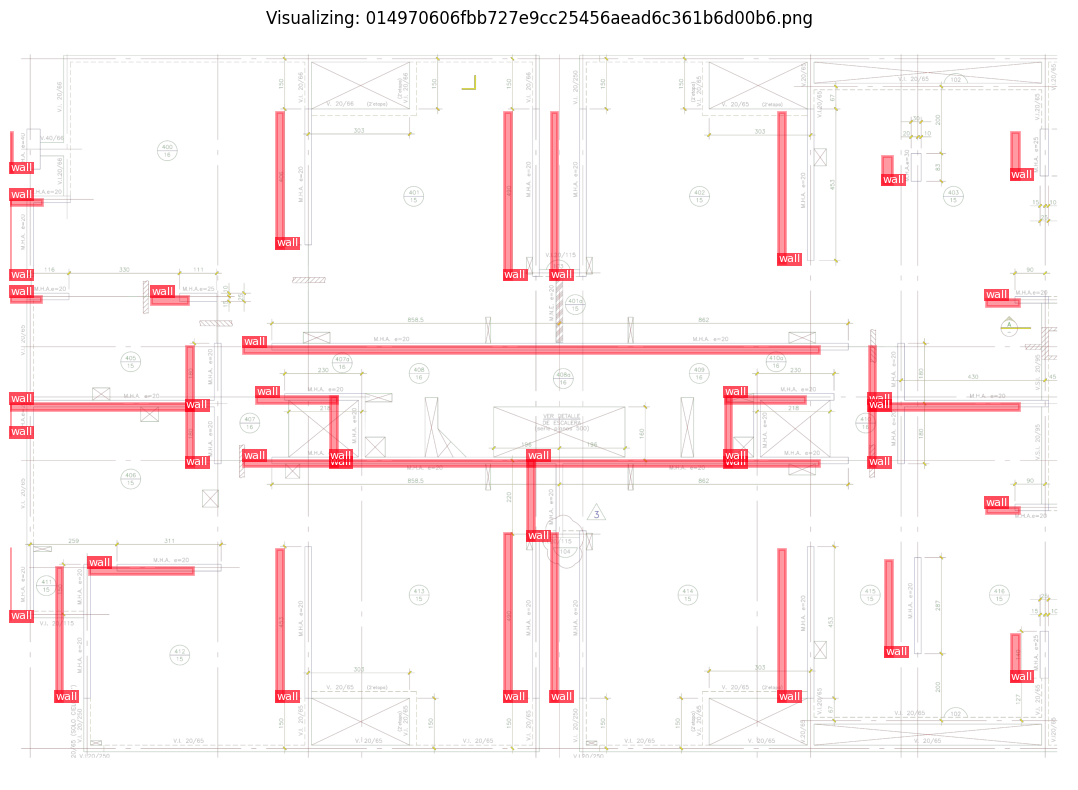

In [15]:
visualize_yolo_segmentation(dataset_path, image_to_show)

In [15]:
# for i in range(0, 10):
#     image_to_show = all_images[i]
#     visualize_yolo_segmentation(dataset_path, image_to_show)